 ------------------------------------------------------------------------------------------------------------------
                                                  ABRHAM NEGASH GELAN
-----------------------------------------------------------------------------------------------------------------------
                                            CS-181 Final Project - Data Analysis
                                                      07/12/22
--------------------------------------------------------------------------------------------------------------------

In [239]:
import os.path
import json
import sqlalchemy as sa
import pandas as pd

In [240]:
def getsqlite_creds(dirname=".",filename="creds.json",source="sqlite"):
    """ Using directory and filename parameters, open a credentials file
        and obtain the two parts needed for a connection string to
        a local provider using the "sqlite" dictionary within
        an outer dictionary.  
        
        Return a scheme and a dbfile
    """
    assert os.path.isfile(os.path.join(dirname, filename))
    with open(os.path.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D[source]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]

def buildConnectionString(source):
    scheme, dbdir, database = getsqlite_creds(source=source)
    template = '{}:///{}/{}.db'
    return template.format(scheme, dbdir, database)

In [241]:
# Build the conection string
cstring = buildConnectionString("sqlite")
print("Connection string:", cstring)

# Connect to the database
engine = sa.create_engine(cstring)
connection = engine.connect()

Connection string: sqlite:///./project.db


In [242]:
%load_ext sql
%sql $cstring

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


**Central Question:** Using countries GDP, life expectancy, and literacy rate reports : “Does a better economic status indicate a better health status and education system in countries?”.

***Simple Analysis of Data***: 

In [243]:
simple = """
SELECT *
FROM indicators

"""


resultset = %sql $simple
simple_df = resultset.DataFrame()
simple_df.head(10)

 * sqlite:///./project.db
Done.


,Country,Region,GDP,Life_Exp,Lit_Rate
0,United States,Americas,20893746,77.2,86.0
1,China,Asia,14722801,78.2,96.8
2,Japan,Asia,5057759,84.8,99.0
3,Germany,Europe,3846414,80.6,99.0
4,India,Asia,2664749,67.2,77.7
5,United Kingdom,Europe,2764198,80.7,99.0
6,France,Europe,2630318,82.5,99.0
7,Canada,Americas,1644037,82.7,99.0
8,Russia,Europe,1483498,69.4,99.7
9,Italy,Europe,1888709,82.9,99.2


Text(0, 0.5, 'Life_Exp == BLUE \n Lit_Rate == Orange')

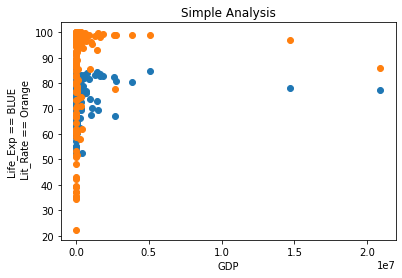

In [244]:
#Plotting

import matplotlib.pyplot as plt
y1=simple_df['Life_Exp']
y2=simple_df['Lit_Rate']
x=simple_df['GDP']

plt.scatter(x,y1)
plt.scatter(x,y2)

plt.title("Simple Analysis")
plt.xlabel("GDP")
plt.ylabel("Life_Exp == BLUE \n Lit_Rate == Orange")

Analysis: On a larger scale, the differences are hard to notice because the disparities between individual countries is very high. We can adjust the scale of the plot to observe the relationship between GDP **and** life expectancy and literacy rate.
An alternative option would be breaking down the overall question into sub-questions.

**Sub-Analysis: *Regional Differences***: Finding average gdp, life expectancy rate, and literacy rate for each region. This can help us observe the relationship between the variables and observe differences among regions.

In [245]:
query1 = """
SELECT Region, ROUND(AVG(GDP),2) AS GDP_Mean_In_Millions, ROUND(AVG(Life_Exp),2) AS Life_exp_Mean, ROUND(AVG(Lit_Rate),2) AS Lit_Rate_Mean
FROM indicators
WHERE Life_Exp NOT NULL AND Lit_Rate NOT NULL
GROUP BY Region
ORDER BY GDP_Mean_In_Millions DESC

"""


resultset = %sql $query1
region_df = resultset.DataFrame()
region_df.head(15)

 * sqlite:///./project.db
Done.


,Region,GDP_Mean_In_Millions,Life_exp_Mean,Lit_Rate_Mean
0,Americas,768962.97,72.58,92.77
1,Asia,710699.96,73.48,90.61
2,Europe,488295.63,78.60,99.07
3,Oceania,139028.33,70.80,92.77
4,Africa,46050.36,62.86,67.26


On a regional level, gdp seems to have a positive relationship with both life expectancy and literacy rate. Europe is the only region with a relatively lower gdp having the highest life expectancy and literacy rate.

A more specific version of this analysis shows the country with the highest gdp for every region in indicators and reports their life expectancy and literacy rate. 


In [246]:
query2 = """
SELECT Country, Region, MAX(GDP) AS region_max, Lit_rate,Life_Exp 
FROM indicators 
GROUP BY Region 
ORDER BY region_max DESC
"""
#SELECT Region, MAX(GDP) AS max_gdp FROM indicators
resultset = %sql $query2
region_df2 = resultset.DataFrame()
region_df2.head(15)

 * sqlite:///./project.db
Done.


,Country,Region,region_max,Lit_Rate,Life_Exp
0,United States,Americas,20893746,86.0,77.2
1,China,Asia,14722801,96.8,78.2
2,Germany,Europe,3846414,99.0,80.6
3,Australia,Oceania,1423473,99.0,84.5
4,Nigeria,Africa,429899,62.0,52.7


Results of this analysis show similar trends to the prior one. 

**Sub-Analysis: *Division***: The first plot was very congested due to the large disparity between countries. Thus, one solution to this would be dividing the countries up into two (countries with a gdp above the mean and countries with gdp less than the mean).

In [247]:
query3 = """
SELECT * FROM indicators WHERE GDP>(SELECT AVG(GDP) FROM indicators)
"""
#SELECT Region, MAX(GDP) AS max_gdp FROM indicators
resultset = %sql $query3
top_df = resultset.DataFrame()
top_df.head(10)

 * sqlite:///./project.db
Done.


,Country,Region,GDP,Life_Exp,Lit_Rate
0,United States,Americas,20893746,77.2,86.0
1,China,Asia,14722801,78.2,96.8
2,Japan,Asia,5057759,84.8,99.0
3,Germany,Europe,3846414,80.6,99.0
4,India,Asia,2664749,67.2,77.7
5,United Kingdom,Europe,2764198,80.7,99.0
6,France,Europe,2630318,82.5,99.0
7,Canada,Americas,1644037,82.7,99.0
8,Russia,Europe,1483498,69.4,99.7
9,Italy,Europe,1888709,82.9,99.2


Text(0, 0.5, 'Life_Exp == BLUE \n Lit_Rate == Orange')

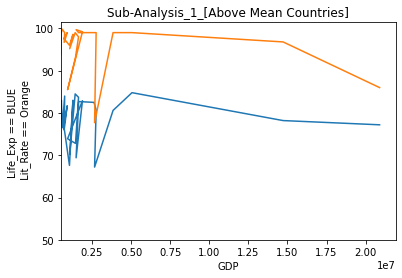

In [248]:
#Plotting

import matplotlib.pyplot as plt2
top_y1=top_df['Life_Exp']
top_y2=top_df['Lit_Rate']
top_x=top_df['GDP']

plt2.plot(top_x,top_y1)
plt2.plot(top_x,top_y2)
plt2.xlim(500000)
plt2.ylim(50)
plt2.title("Sub-Analysis_1_[Above Mean Countries]")
plt2.xlabel("GDP")
plt2.ylabel("Life_Exp == BLUE \n Lit_Rate == Orange")

Although the plot would still be congested if not for the limits set on the axis, it is relatively less dense. Using the SQL statement, I was able to set the axis within a smaller range by executing the statement using various ordering clauses and finding the smallest and largest values for each indicator.

In [249]:
query4 = """
SELECT * FROM indicators WHERE GDP<(SELECT AVG(GDP) FROM indicators)
"""
#SELECT Region, MAX(GDP) AS max_gdp FROM indicators
resultset = %sql $query4
bottom_df = resultset.DataFrame()
bottom_df.head(10)

 * sqlite:///./project.db
Done.


,Country,Region,GDP,Life_Exp,Lit_Rate
0,Argentina,Americas,383067,75.4,99.00
1,Israel,Asia,407101,82.3,97.80
2,Ireland,Europe,425889,82.0,99.00
3,Norway,Europe,362522,83.2,100.00
4,Nigeria,Africa,429899,52.7,62.00
5,United Arab Emirates,Asia,358869,78.7,97.60
6,Egypt,Africa,369309,70.2,71.20
7,Austria,Europe,433258,81.6,98.00
8,Bangladesh,Asia,329484,72.4,74.66
9,Malaysia,Asia,336664,74.9,95.00


Text(0, 0.5, 'Life_Exp == BLUE \n Lit_Rate == Orange')

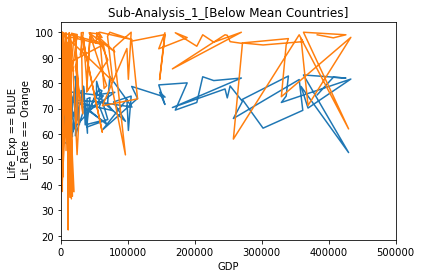

In [250]:
#Plotting

import matplotlib.pyplot as plt3
bottom_y1=bottom_df['Life_Exp']
bottom_y2=bottom_df['Lit_Rate']
bottom_x=bottom_df['GDP']

plt3.plot(bottom_x,bottom_y1)
plt3.plot(bottom_x,bottom_y2)
plt3.xlim(0,500000)

plt2.title("Sub-Analysis_1_[Below Mean Countries]")
plt2.xlabel("GDP")
plt2.ylabel("Life_Exp == BLUE \n Lit_Rate == Orange")

What is different here is that majority of the countries in the world belong in this group. Therefore, the plot had a similar structure to that of the initial one. It is difficult to observe a relationship between the indicators because values vary vastly. However it can be seen that countries within the second half of this plot (higher gdp) are seen to have literacy rates and life expectancies that are at least 50%

**Sub-Analysis: *Regional Analysis*** : A final approach to minimize these disrepancies is to perform analysis on each region. Instead of creating a statement query for every region, the cell below contains a function that takes in a region as input to perform the analysis made above for the region inserted in the parameter.

In [251]:
#For Above mean analysis within region
def departmentsByRegion1(connection,region):
    top_query ="""
    SELECT * 
    FROM indicators 
    WHERE GDP<(SELECT AVG(GDP) FROM indicators) AND Region='{}'
    """
    query1 = top_query.format(region)
    top_regional= pd.read_sql_query(query1, con=connection)
    
    #Plotting
    import matplotlib.pyplot as plt4
    top_regional_y1=top_regional['Life_Exp']
    top_regional_y2=top_regional['Lit_Rate']
    top_regional_x=top_regional['GDP']

    plt4.plot(top_regional_x,top_regional_y1)
    plt4.plot(top_regional_x,top_regional_y2)

    plt4.title("Regional Analysis [Above Mean Countries]")
    plt4.xlabel("GDP")
    plt4.ylabel("Life_Exp == BLUE \n Lit_Rate == Orange")
    return top_regional.head(10)


#For Below mean analysis within region
def departmentsByRegion2(connection,region):
    bottom_query ="""
    SELECT * 
    FROM indicators 
    WHERE GDP>(SELECT AVG(GDP) FROM indicators) AND Region='{}'
    """
    query2 = bottom_query.format(region)
    bottom_regional= pd.read_sql_query(query2, con=connection)
    
    #Plotting
    import matplotlib.pyplot as plt5
    bottom_regional_y1=bottom_regional['Life_Exp']
    bottom_regional_y2=bottom_regional['Lit_Rate']
    bottom_regional_x=bottom_regional['GDP']

    plt5.plot(bottom_regional_x,bottom_regional_y1)
    plt5.plot(bottom_regional_x,bottom_regional_y2)

    plt5.title("Regional Analysis [Below Mean Countries]")
    plt5.xlabel("GDP")
    plt5.ylabel("Life_Exp == BLUE \n Lit_Rate == Orange")
    return bottom_regional.head(10)

In [252]:
#Example Regional Analysis

#departmentsByRegion1(connection,'Europe')
#departmentsByRegion2(connection,'Europe')

***SUMMARY***

Overall, it was difficult to compute the analysis with all the data extracted. Performing smaller analysis by performing divisions made it easier to look at the data.
Although a linear relationship was not observed, all plots show that countries with higher GDP tend to also have higher life expectancy and literacy rates. In terms of challenges faced overall, it was hard to increase the complexity of the project. Due to having one table to work with, statements did not include joins; however, I tried hard to include more complex queries that work for a single table.